In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [2]:
from datasets import load_dataset

# Download and load the MSLR-WEB10K dataset directly from Hugging Face
print("Loading MSLR-WEB10k dataset from Hugging Face...")
dataset = load_dataset("philipphager/MSLR-WEB10k")

# Convert to pandas DataFrames for easier manipulation
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

print(f"Dataset loaded successfully!")
print(f"Training set: {len(train_df)} queries")
print(f"Validation set: {len(val_df)} queries")
print(f"Test set: {len(test_df)} queries")

Loading MSLR-WEB10k dataset from Hugging Face...


train.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/86.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset loaded successfully!
Training set: 6000 queries
Validation set: 2000 queries
Test set: 2000 queries


In [3]:
# @title Exploring dataset
train_df.head()

,query,labels,features,n
0,1,"[2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[[3.0, 3.0, 0.0, 0.0, 3.0, 1.0, 1.0, 0.0, 0.0,...",86
1,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, ...","[[3.0, 0.0, 2.0, 0.0, 3.0, 1.0, 0.0, 0.666667,...",103
2,7,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[2.0, 0.0, 2.0, 0.0, 2.0, 0.666667, 0.0, 0.66...",111
3,16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",106
4,19,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, ...","[[2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0,...",76


In [4]:
def get_label_distribution(df):
    all_labels = []
    for label in df['labels']:
        all_labels.extend(label)
    all_labels = np.array(all_labels)
    unique, counts = np.unique(all_labels, return_counts=True)
    return unique, counts

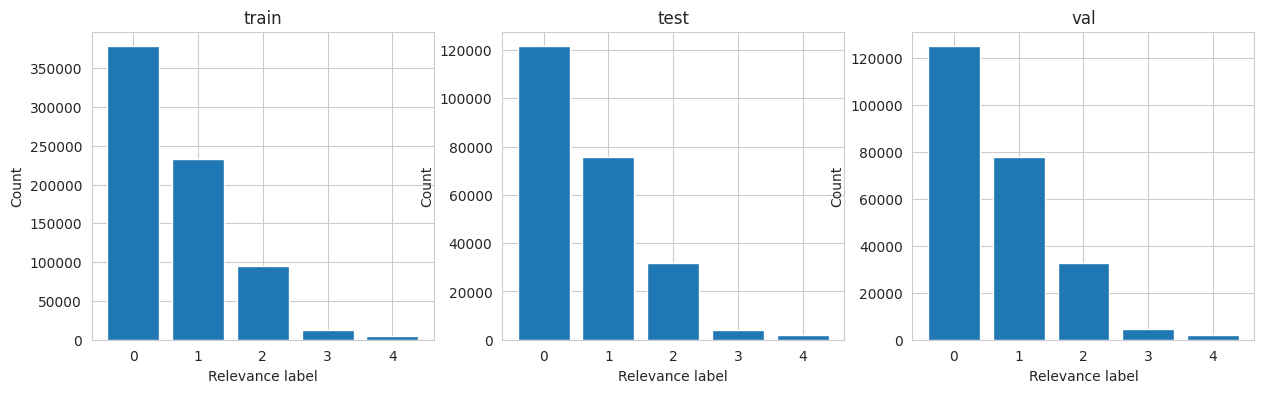

In [5]:
train_labels, train_count = get_label_distribution(train_df)
val_labels, val_count = get_label_distribution(val_df)
test_labels, test_count = get_label_distribution(test_df)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for axis, data, title in zip(axes, [(train_labels, train_count), (val_labels, val_count), (test_labels, test_count)], [
    'train', 'test', 'val'
]):
    axis.set_title(title)
    axis.set_xlabel('Relevance label')
    axis.set_ylabel('Count')
    axis.bar(data[0], data[1])

plt.show()

In [6]:
train_df['n'].describe()

count    6000.000000
mean      120.568667
std        70.153966
min         1.000000
25%        77.000000
50%       110.000000
75%       152.000000
max       809.000000
Name: n, dtype: float64

In [7]:
class RankingDataset(Dataset):
    def __init__(self, df, feature_norm='standard'):
        self.queries = []
        self.all_features = []
        self.all_labels = []

        # Process each query
        for idx, row in df.iterrows():
            features = np.stack(row['features'])  # Shape: (n_docs, n_features)
            labels = row['labels']

            self.queries.append({
                'query_id': row['query'],
                'features': features,
                'labels': labels,
                'n_docs': row['n']
            })

            self.all_features.append(features)
            self.all_labels.extend(labels)

        # Compute normalization statistics
        all_features_concat = np.vstack(self.all_features)

        if feature_norm == 'standard':
            self.feature_mean = np.mean(all_features_concat, axis=0)
            self.feature_std = np.std(all_features_concat, axis=0) + 1e-6
        elif feature_norm == 'minmax':
            self.feature_min = np.min(all_features_concat, axis=0)
            self.feature_max = np.max(all_features_concat, axis=0)
            self.feature_range = self.feature_max - self.feature_min + 1e-6

        self.feature_norm = feature_norm
        self.feature_dim = all_features_concat.shape[1]

        print(f"Dataset created: {len(self.queries)} queries, {len(self.all_labels)} documents")
        print(f"Feature dimension: {self.feature_dim}")

    def normalize_features(self, features):
        if self.feature_norm == 'standard':
            return (features - self.feature_mean) / self.feature_std
        elif self.feature_norm == 'minmax':
            return (features - self.feature_min) / self.feature_range
        else:
            return features

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        query = self.queries[idx]
        features = self.normalize_features(query['features'])

        return {
            'query_id': query['query_id'],
            'features': torch.FloatTensor(features),
            'labels': torch.FloatTensor(query['labels']),
            'n_docs': query['n_docs']
        }

# Create datasets
train_dataset = RankingDataset(train_df, feature_norm='standard')
val_dataset = RankingDataset(val_df, feature_norm='standard')
test_dataset = RankingDataset(test_df, feature_norm='standard')

# Apply same normalization to validation and test
val_dataset.feature_mean = train_dataset.feature_mean
val_dataset.feature_std = train_dataset.feature_std
test_dataset.feature_mean = train_dataset.feature_mean
test_dataset.feature_std = train_dataset.feature_std

Dataset created: 6000 queries, 723412 documents
Feature dimension: 136
Dataset created: 2000 queries, 235259 documents
Feature dimension: 136
Dataset created: 2000 queries, 241521 documents
Feature dimension: 136


In [8]:
class RankNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.2):
        super(RankNet, self).__init__()

        layers = []
        prev_dim = input_dim

        # Build layers without BatchNorm to avoid single-sample issues
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        # Final scoring layer
        layers.append(nn.Linear(prev_dim, 1))

        self.model = nn.Sequential(*layers)

        # Feature attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(input_dim, max(input_dim // 4, 16)),
            nn.ReLU(),
            nn.Linear(max(input_dim // 4, 16), input_dim),
            nn.Sigmoid()
        )

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        # Apply attention to features
        attention_weights = self.attention(x)
        x = x * attention_weights

        # Get relevance scores
        scores = self.model(x)
        return scores.squeeze(-1)

# Initialize model
model = RankNet(input_dim=train_dataset.feature_dim, 
                hidden_dims=[512, 256, 128, 64],
                dropout=0.3)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")
print(f"\nModel architecture:")
print(model)

Model parameters: 252,107

Model architecture:
RankNet(
  (model): Sequential(
    (0): Linear(in_features=136, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
  (attention): Sequential(
    (0): Linear(in_features=136, out_features=34, bias=True)
    (1): ReLU()
    (2): Linear(in_features=34, out_features=136, bias=True)
    (3): Sigmoid()
  )
)


In [9]:
class RankingLoss(nn.Module):
    def __init__(self, loss_type='listnet', margin=1.0):
        super(RankingLoss, self).__init__()
        self.loss_type = loss_type
        self.margin = margin

    def forward(self, scores, label):
        if self.loss_type == 'listnet':
            return self.listnet_loss(scores, label)
        elif self.loss_type == 'ranknet':
            return self.ranknet_loss(scores, label)
        elif self.loss_type == 'lambdarank':
            return self.lambdarank_loss(scores, label)

    def listnet_loss(self, scores, label):
        y_true = torch.softmax(label, dim=-1)
        y_pred = torch.softmax(scores, dim=-1)
        return -torch.sum(y_true * torch.log(y_pred + 1e-8))

        
    def ranknet_loss(self, scores, label):
        n = scores.shape[0]
        if n < 2:
            return torch.tensor(0.0, device=scores.device)

        # Create all pairs
        scores_diff = scores.unsqueeze(1) - scores.unsqueeze(0)
        labels_diff = labels.unsqueeze(1) - labels.unsqueeze(0)

        # Only consider pairs with different labels
        mask = labels_diff != 0

        if mask.sum() == 0:
            return torch.tensor(0.0, device=scores.device)

        # Sigmoid on score differences
        s_ij = torch.sigmoid(scores_diff[mask])

        # Target: 1 if label_i > label_j, 0 otherwise
        t_ij = (labels_diff[mask] > 0).float()

        # Binary cross entropy
        loss = -torch.mean(t_ij * torch.log(s_ij + 1e-8) + 
                          (1 - t_ij) * torch.log(1 - s_ij + 1e-8))
        return loss
        

   
    def lambdarank_loss(self, scores, labels):
        """LambdaRank loss with NDCG weighting"""
        n = scores.shape[0]
        if n < 2:
            return torch.tensor(0.0, device=scores.device)

        # Sort by predicted scores
        sorted_indices = torch.argsort(scores, descending=True)
        sorted_labels = labels[sorted_indices]

        # Compute NDCG weights
        dcg_max = self._dcg(torch.sort(labels, descending=True)[0])
        if dcg_max == 0:
            return torch.tensor(0.0, device=scores.device)

        # Pairwise loss with NDCG weights
        loss = self.ranknet_loss(scores, labels)

        # Weight by NDCG change
        current_dcg = self._dcg(sorted_labels)
        ndcg = current_dcg / (dcg_max + 1e-8)

        return loss * (1 - ndcg)

    def _dcg(self, labels, k=None):
        """Discounted Cumulative Gain"""
        if k is None:
            k = labels.shape[0]
        k = min(k, labels.shape[0])

        gains = 2 ** labels[:k] - 1
        discounts = torch.log2(torch.arange(2, k + 2, device=labels.device).float())
        return torch.sum(gains / discounts)
    

criterion = RankingLoss(loss_type='listnet')


In [10]:
a = np.array([1.0, 0, 0, 2.0, 3.0, 0, 4])
np.where(a > 0)

(array([0, 3, 4, 6]),)

In [11]:
class RankingMetrics:
    @staticmethod
    def ndcg(labels, scores, k=10):
        """Normalized Discounted Cumulative Gain at k"""
        # Sort by scores
        sorted_indices = np.argsort(-scores)
        sorted_labels = labels[sorted_indices]

        # DCG@k
        k = min(k, len(labels))
        gains = 2 ** sorted_labels[:k] - 1
        discounts = np.log2(np.arange(2, k + 2))
        dcg = np.sum(gains / discounts)

        # Ideal DCG@k
        ideal_sorted_labels = np.sort(labels)[::-1]
        ideal_gains = 2 ** ideal_sorted_labels[:k] - 1
        idcg = np.sum(ideal_gains / discounts)

        # NDCG
        if idcg == 0:
            return 0.0
        return dcg / idcg

    @staticmethod
    def map_score(labels, scores):
        """Mean Average Precision"""
        # Sort by scores
        sorted_indices = np.argsort(-scores)
        sorted_labels = labels[sorted_indices]

        # Calculate AP
        relevant_docs = np.where(sorted_labels > 0)[0]
        if len(relevant_docs) == 0:
            return 0.0

        precisions = []
        for i, pos in enumerate(relevant_docs):
            precision = (i + 1) / (pos + 1)
            precisions.append(precision)

        return np.mean(precisions)

    @staticmethod
    def mrr(labels, scores):
        """Mean Reciprocal Rank"""
        # Sort by scores
        sorted_indices = np.argsort(-scores)
        sorted_labels = labels[sorted_indices]

        # Find first relevant document
        for rank, label in enumerate(sorted_labels, 1):
            if label > 0:
                return 1.0 / rank
        return 0.0

# Test metrics
metrics = RankingMetrics()
test_labels = np.array([3, 2, 0, 1, 0])
test_scores = np.array([0.9, 0.8, 0.3, 0.6, 0.1])

print("Example metrics:")
print(f"NDCG@5: {metrics.ndcg(test_labels, test_scores, k=5):.4f}")
print(f"MAP: {metrics.map_score(test_labels, test_scores):.4f}")
print(f"MRR: {metrics.mrr(test_labels, test_scores):.4f}")

Example metrics:
NDCG@5: 1.0000
MAP: 1.0000
MRR: 1.0000


In [12]:
def train_epoch(model, dataset, optimizer, criterion):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    n_queries = 0

    for query_data in tqdm(dataset, desc="Training"):
        features = query_data['features'].to(device)
        labels = query_data['labels'].to(device)

        # Skip queries with all same labels
        if torch.std(labels) == 0:
            continue

        optimizer.zero_grad()

        # Forward pass
        scores = model(features)
        loss = criterion(scores, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        n_queries += 1

    return total_loss / max(n_queries, 1)    


In [13]:
def evaluate_model(model, dataset, metrics_obj, k_values=[1, 3, 5, 10]):
    """Evaluate model on a dataset"""
    model.eval()

    ndcg_scores = {k: [] for k in k_values}
    map_scores = []
    mrr_scores = []

    with torch.no_grad():
        for query_data in dataset:
            features = query_data['features'].to(device)
            labels = query_data['labels'].numpy()

            # Get predictions
            scores = model(features).cpu().numpy()

            # Calculate metrics
            for k in k_values:
                ndcg_scores[k].append(metrics_obj.ndcg(labels, scores, k))
            map_scores.append(metrics_obj.map_score(labels, scores))
            mrr_scores.append(metrics_obj.mrr(labels, scores))

    results = {
        'MAP': np.mean(map_scores),
        'MRR': np.mean(mrr_scores)
    }

    for k in k_values:
        results[f'NDCG@{k}'] = np.mean(ndcg_scores[k])

    return results

In [14]:
# Training configuration
num_epochs = 3  # Reduced for faster demo
learning_rate = 0.001
patience = 3

# Initialize optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

# Tracking
metrics_obj = RankingMetrics()
history = defaultdict(list)
best_ndcg = 0
patience_counter = 0

print("Starting training...\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("="* 50)

    # Training
    train_loss = train_epoch(model, train_dataset, optimizer, criterion)
    history['train_loss'].append(train_loss)
    print(f"Training Loss: {train_loss:.4f}")

    # Validation
    val_metrics = evaluate_model(model, val_dataset, metrics_obj)

    for metric_name, value in val_metrics.items():
        history[f'val_{metric_name}'].append(value)
        print(f"Val {metric_name}: {value:.4f}", end="  ")
    print()

    # Learning rate scheduling
    scheduler.step(val_metrics['NDCG@10'])

    # Early stopping
    if val_metrics['NDCG@10'] > best_ndcg:
        best_ndcg = val_metrics['NDCG@10']
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_ranking_model.pth')
        print(f"✓ New best model saved (NDCG@10: {best_ndcg:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

print("\nTraining completed!")


Starting training...


Epoch 1/3


Training:   0%|          | 0/6000 [00:00<?, ?it/s]

Training Loss: 4.6149
Val MAP: 0.5854  Val MRR: 0.7724  Val NDCG@1: 0.3606  Val NDCG@3: 0.3664  Val NDCG@5: 0.3773  Val NDCG@10: 0.4056  
✓ New best model saved (NDCG@10: 0.4056)

Epoch 2/3


Training:   0%|          | 0/6000 [00:00<?, ?it/s]

Training Loss: 4.6061
Val MAP: 0.5934  Val MRR: 0.7968  Val NDCG@1: 0.3795  Val NDCG@3: 0.3794  Val NDCG@5: 0.3910  Val NDCG@10: 0.4152  
✓ New best model saved (NDCG@10: 0.4152)

Epoch 3/3


Training:   0%|          | 0/6000 [00:00<?, ?it/s]

Training Loss: 4.6007
Val MAP: 0.5970  Val MRR: 0.8024  Val NDCG@1: 0.3873  Val NDCG@3: 0.3843  Val NDCG@5: 0.3933  Val NDCG@10: 0.4175  
✓ New best model saved (NDCG@10: 0.4175)

Training completed!


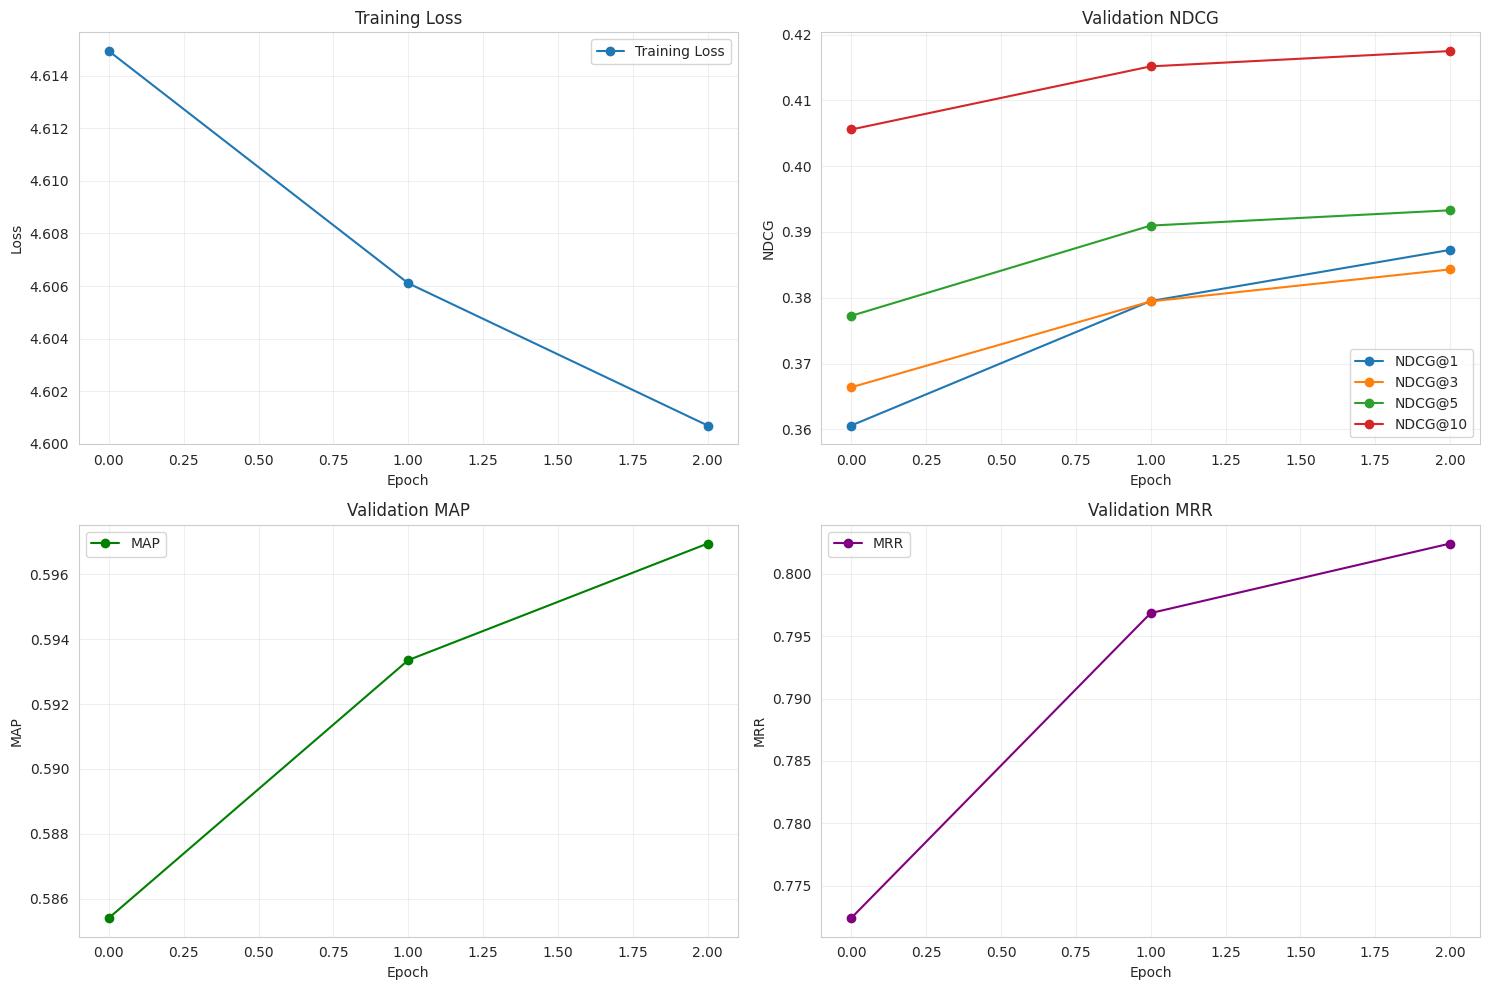

In [15]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curve
axes[0, 0].plot(history['train_loss'], label='Training Loss', marker='o')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# NDCG curves
for k in [1, 3, 5, 10]:
    axes[0, 1].plot(history[f'val_NDCG@{k}'], label=f'NDCG@{k}', marker='o')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('NDCG')
axes[0, 1].set_title('Validation NDCG')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MAP curve
axes[1, 0].plot(history['val_MAP'], label='MAP', color='green', marker='o')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MAP')
axes[1, 0].set_title('Validation MAP')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MRR curve
axes[1, 1].plot(history['val_MRR'], label='MRR', color='purple', marker='o')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MRR')
axes[1, 1].set_title('Validation MRR')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()